In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F


In [2]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

True
1
0
GeForce RTX 2080 with Max-Q Design


In [3]:
data_dir = '../../../Images/BottleStoodUp_atNight/Positive'      #This is for the home laptop
# data_dir = '../../../../BottleStoodUp_atNight/Positive/'        #For the work laptop

In [4]:
# transform_characteristics = transforms.Compose([transforms.Resize(255),
#                                 transforms.CenterCrop(224),
#                                 transforms.ToTensor()])

# transform_characteristics = transforms.Compose([transforms.ToTensor(),
#                                                 transforms.Resize(255),
#                                                 transforms.CenterCrop(224)])


transform_characteristics = transforms.Compose([transforms.Grayscale(),
                                                transforms.ToTensor(),
                                                transforms.Resize(255),
                                                transforms.CenterCrop(224)])
dataset = datasets.ImageFolder(data_dir, transform=transform_characteristics)
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=15, shuffle=True)
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=15)

The dataloader is compoosed of 12 batches, each of them of size 15 making a total of: 180, which is enough for storing the 179 images that we have in the positive dataset

In [5]:
print(len(dataloader))

12


In [6]:
images, labels = next(iter(dataloader))
print("The images are stored in a variable of type: ", type(images))
print("The classes labels are: ", labels)
print(torch.min(images), torch.max(images))

c:\Users\alexj\.conda\envs\tfm_3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


The images are stored in a variable of type:  <class 'torch.Tensor'>
The classes labels are:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor(0.) tensor(1.)


# Showing one sample of the training set images

Grabbing only one image of the training set, permuting its shape sizes and converting to numpy to able to display it.

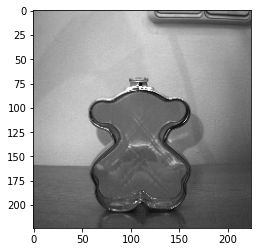

In [7]:
single_img = images[0]
single_img_permuted = single_img.permute(1, 2, 0) 
single_img_numpy = single_img_permuted.detach().numpy()

plt.imshow(single_img_numpy, cmap='gray', vmin=0, vmax=1)
# plt.imshow(single_img_numpy)

# Building the model Autoencoder model

In [8]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()               
        # 15, 1, 224, 224.  Batch size, input channels, shape of the image.
        input_channels = 1              # number of channels of the input image
        output_channels = 110           # ~= 224/2. Shape of the input image divided by 2 approximately. 
        kernel_size = 9
        padding_val = 1
        stride_val = 5

        
        output_channels_layer2 = output_channels*2+5

        output_channels_layer3 = output_channels_layer2*2
        
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size, stride=stride_val, padding=padding_val),         # input image channels, output channels, kernel size (filter). Dimension rseult: -> 15, 110, 44, 44. Batch size, channel output, output image shape.
            nn.ReLU(),
            nn.Conv2d(output_channels, output_channels_layer2, kernel_size, stride=stride_val, padding=padding_val), # Dimension rseult: -> 15, 225, 8, 8
            nn.ReLU(),
            nn.Conv2d(output_channels_layer2, output_channels_layer3, 8) # Dimension rseult: -> 15, 450, 1, 1
        )
        
        # Initial dimension for this part of the model: 15 , 450, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(output_channels_layer3, output_channels_layer2, 8),  # Dimension rseult: -> 15, 225, 8, 8
            nn.ReLU(),
            nn.ConvTranspose2d(output_channels_layer2, output_channels, kernel_size, stride=stride_val, padding=padding_val, output_padding=2), # Dimension rseult: -> 15, 110, 44, 44
            nn.ReLU(),
            nn.ConvTranspose2d(output_channels, input_channels, kernel_size, stride=stride_val, padding=padding_val, output_padding=2), # Dimension rseult: -> 15, 1, 224, 224
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
 
# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh

Making sure to use the GPU for the trainig stage

In [9]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)

cuda:0


In [10]:
model = Autoencoder()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

In [11]:
model.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 110, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(110, 225, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(225, 450, kernel_size=(8, 8), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(450, 225, kernel_size=(8, 8), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(225, 110, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1), output_padding=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(110, 1, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1), output_padding=(2, 2))
    (5): Sigmoid()
  )
)

In [12]:
torch.cuda.empty_cache()

In [13]:
# Point to training loop video
num_epochs = 300
outputs = []
for epoch in range(num_epochs):
    for (img, _) in dataloader:     # This iterates over the batches of images.
        img = img.to(device)
        # Forward pass
        recon = model(img)          # The entire batch of images is passed to the model
        loss = criterion(recon, img)

        # Backward and optimize
        optimizer.zero_grad()       # Sets the gradients of all optimized torch.Tensors to zero
        loss.backward()             # The accumulation (or sum) of all the gradients is calculated     
        optimizer.step()            # can be called once the gradients are computed 

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0120
Epoch:2, Loss:0.0082
Epoch:3, Loss:0.0064
Epoch:4, Loss:0.0067
Epoch:5, Loss:0.0049
Epoch:6, Loss:0.0058
Epoch:7, Loss:0.0058
Epoch:8, Loss:0.0057
Epoch:9, Loss:0.0046
Epoch:10, Loss:0.0058
Epoch:11, Loss:0.0052
Epoch:12, Loss:0.0041
Epoch:13, Loss:0.0058
Epoch:14, Loss:0.0053
Epoch:15, Loss:0.0035
Epoch:16, Loss:0.0037
Epoch:17, Loss:0.0028
Epoch:18, Loss:0.0028
Epoch:19, Loss:0.0023
Epoch:20, Loss:0.0026
Epoch:21, Loss:0.0030
Epoch:22, Loss:0.0031
Epoch:23, Loss:0.0023
Epoch:24, Loss:0.0026
Epoch:25, Loss:0.0020
Epoch:26, Loss:0.0021
Epoch:27, Loss:0.0021
Epoch:28, Loss:0.0025
Epoch:29, Loss:0.0022
Epoch:30, Loss:0.0018
Epoch:31, Loss:0.0022
Epoch:32, Loss:0.0024
Epoch:33, Loss:0.0020
Epoch:34, Loss:0.0018
Epoch:35, Loss:0.0018
Epoch:36, Loss:0.0018
Epoch:37, Loss:0.0020
Epoch:38, Loss:0.0014
Epoch:39, Loss:0.0017
Epoch:40, Loss:0.0016
Epoch:41, Loss:0.0014
Epoch:42, Loss:0.0017
Epoch:43, Loss:0.0015
Epoch:44, Loss:0.0015
Epoch:45, Loss:0.0017
Epoch:46, Loss:0.00

Saving and loading a model

In [14]:
filepath = "../../models/pytorchModels/PytorchModel_grayscale_withCUDA"


In [15]:
torch.save(model.state_dict(), filepath)

In [16]:
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 110, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(110, 225, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(225, 450, kernel_size=(8, 8), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(450, 225, kernel_size=(8, 8), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(225, 110, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1), output_padding=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(110, 1, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1), output_padding=(2, 2))
    (5): Sigmoid()
  )
)

In [17]:
# For loading the model 
model.load_state_dict(torch.load(filepath))
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 110, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(110, 225, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(225, 450, kernel_size=(8, 8), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(450, 225, kernel_size=(8, 8), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(225, 110, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1), output_padding=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(110, 1, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1), output_padding=(2, 2))
    (5): Sigmoid()
  )
)

Once the model has been trained we will show the results:

The below function is used for formatting the image to make it able to be showed.

In [18]:
#Utility functions to un-normalize and display an image
def imshow(img):
    # img = img / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0)), cmap='gray', vmin=0, vmax=1) 

Original Images


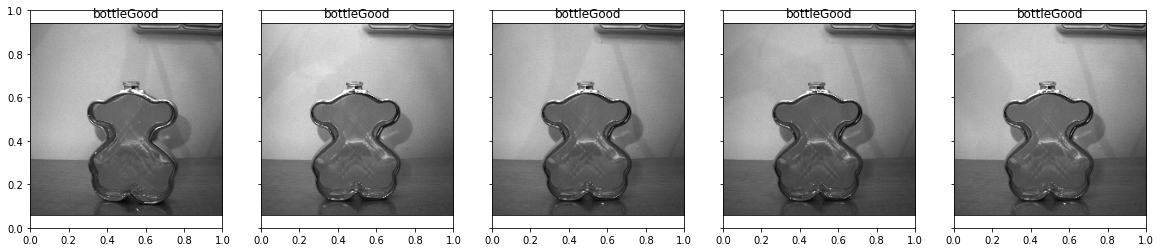

Reconstructed Images


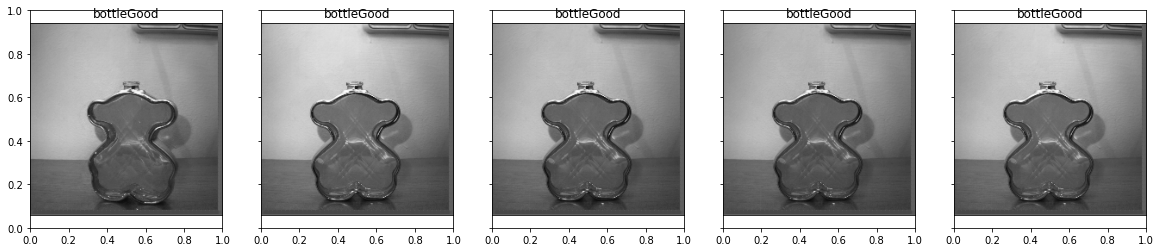

In [19]:
#Batch of test images
dataiter = iter(dataloader)
images, labels = next(dataiter)
images, labels = images.cuda(), labels.cuda() # add this line for displaying the image
#Sample outputs
output = model(images)

images = images.cpu().numpy()

# output = output.view(32, 3, 224, 224)
output = output.view(15, 1, 224, 224)       # Because the batch size was changed to 15
output = output.cpu().detach().numpy()

#Define the image classes
classes = ['bottleGood']

#Original Images
print("Original Images")
# plt.figure(figsize=(15, 15))
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(20,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])
plt.show()

#Reconstructed Images
print('Reconstructed Images')
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(20,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(output[idx])
    ax.set_title(classes[labels[idx]])
plt.show() 

# Quantifying the reconstruction error

Performing the computation of the reconstruction error of all the images in the dataset. Additionally, consider the mean reconstruction error, rather than the direct sum of these.

In [20]:
X = dataset[0]
image_in_tensor = X[0]
result_lst = []
n_features = len(image_in_tensor[0])  # 65
for i in range(len(dataset)):
    X = dataset[i]
    image_in_tensor = X[0]
    image_in_tensor = image_in_tensor.cuda()            # If using the GPU
    with torch.no_grad():
        Y = model(image_in_tensor)  # should be same as X
    err = torch.sum((image_in_tensor-Y)*(image_in_tensor-Y)).item()  # SSE all features
    err = err/(n_features*3)        # dividing by n_features*3 becuase we have three channels
    result_lst.append( (i,err) )     # idx of data item, err
print(result_lst)

[(0, 0.13220369248163133), (1, 0.08990517116728283), (2, 0.0995949109395345), (3, 0.08262198879605248), (4, 0.08138075329008557), (5, 0.08000500996907552), (6, 0.07861835615975517), (7, 0.08059136072794597), (8, 0.08254593894595191), (9, 0.08301586196536109), (10, 0.0737518583025251), (11, 0.0701475427264259), (12, 0.0907958121526809), (13, 0.0881958972840082), (14, 0.0823588768641154), (15, 0.07738607838040307), (16, 0.0806587707428705), (17, 0.08761877105349586), (18, 0.08741475854601179), (19, 0.11027776627313524), (20, 0.07341004553295317), (21, 0.07190639632088798), (22, 0.05724793388730004), (23, 0.05151872407822382), (24, 0.049334105991181876), (25, 0.0769147134962536), (26, 0.0688407194046747), (27, 0.06883594535645984), (28, 0.06465894835335868), (29, 0.05957681224459693), (30, 0.06297596863337926), (31, 0.06614414283207484), (32, 0.060236851374308266), (33, 0.05908842313857306), (34, 0.061847323463076635), (35, 0.05013138907296317), (36, 0.0528393927074614), (37, 0.0602439471

In [21]:
result_lst.sort(key=lambda x: x[1], \
reverse=True)  # high error to low
print(result_lst)

[(175, 0.14284367788405644), (0, 0.13220369248163133), (178, 0.1316882542201451), (176, 0.13148178373064315), (177, 0.1281913575671968), (155, 0.1156244050888788), (19, 0.11027776627313524), (166, 0.10047344934372675), (2, 0.0995949109395345), (102, 0.0938992386772519), (12, 0.0907958121526809), (1, 0.08990517116728283), (13, 0.0881958972840082), (17, 0.08761877105349586), (18, 0.08741475854601179), (167, 0.085336514881679), (9, 0.08301586196536109), (3, 0.08262198879605248), (8, 0.08254593894595191), (14, 0.0823588768641154), (4, 0.08138075329008557), (16, 0.0806587707428705), (7, 0.08059136072794597), (5, 0.08000500996907552), (168, 0.07921348299298968), (6, 0.07861835615975517), (15, 0.07738607838040307), (156, 0.07717939217885335), (25, 0.0769147134962536), (146, 0.07656080382210868), (165, 0.07577027593340192), (163, 0.07507412774222237), (164, 0.07432955219632104), (51, 0.0741033781142462), (39, 0.07400946390061151), (10, 0.0737518583025251), (20, 0.07341004553295317), (172, 0.07

Gaphically the distribution of the reconstruction error values is shown below:

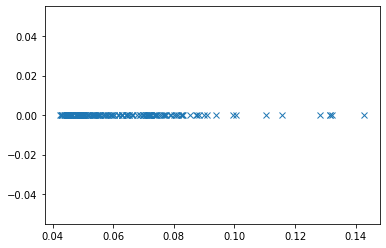

In [22]:
errors_list = []
for i in range(len(result_lst)):
    errors_list.append(result_lst[i][1])  

val = 0. # this is the value where you want the data to appear on the y-axis.
plt.plot(errors_list, np.zeros_like(errors_list) + val, 'x')
plt.show()

In [23]:
average_recon_error = np.mean(np.array(errors_list))  
stdev_recon_error = np.std(np.array(errors_list)) 
min_prob = np.min(errors_list)
max_prob = np.max(errors_list)
print("THIS IS FOR THE TRAINING (NON-ANOMALY) IMAGES\n")
print("The average of the errors list is: ", average_recon_error)
print("The standard deviation of the errors list is: ", stdev_recon_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

THIS IS FOR THE TRAINING (NON-ANOMALY) IMAGES

The average of the errors list is:  0.06198303580252407
The standard deviation of the errors list is:  0.018923037896527585
The min value of the errors list is:  0.0424121447971889
The max value of the errors list is:  0.14284367788405644


## Checking the MSE reconstruction error of the anomaly images

We first load the anomaly images dataset

In [24]:
data_anomalies = '../../../Images/BottleStoodUp_atNight/Anomalies2.0'      #This is for the home laptop
transform_characteristics = transforms.Compose([transforms.Grayscale(),
                                                transforms.ToTensor(),
                                                transforms.Resize(255),
                                                transforms.CenterCrop(224)])
dataset_anomalies = datasets.ImageFolder(data_anomalies, transform=transform_characteristics)
dataloader_anomalies = torch.utils.data.DataLoader(dataset_anomalies, batch_size=32, shuffle=True)

In [25]:
result_lst = []

# Grabbing only the first image of the anomalies dataset
X = dataset_anomalies[0]
image_in_tensor = X[0]
image_in_tensor = image_in_tensor.cuda()            # If using the GPU
n_features = len(image_in_tensor[0])  # Get the size of one image of the anomaly images dataset. This is supposed to be 224
for i in range(len(dataset_anomalies)):
    X = dataset_anomalies[i]
    image_in_tensor = X[0]
    image_in_tensor = image_in_tensor.cuda()            # If using the GPU
    with torch.no_grad():
        Y = model(image_in_tensor)  # should be same as X
    err = torch.sum((image_in_tensor-Y)*(image_in_tensor-Y)).item()  # SSE all features
    err = err/(n_features*3)        # dividing by n_features*3 becuase we have three channels
    result_lst.append( (i,err) )     # idx of data item, err
print(result_lst)

[(0, 0.08968755177089147), (1, 0.05641514914376395), (2, 0.08795703025091262), (3, 0.1392558188665481), (4, 0.09638843082246326), (5, 0.06077075004577637)]


In [26]:
result_lst.sort(key=lambda x: x[1], \
reverse=True)  # high error to low
print(result_lst)

[(3, 0.1392558188665481), (4, 0.09638843082246326), (0, 0.08968755177089147), (2, 0.08795703025091262), (5, 0.06077075004577637), (1, 0.05641514914376395)]


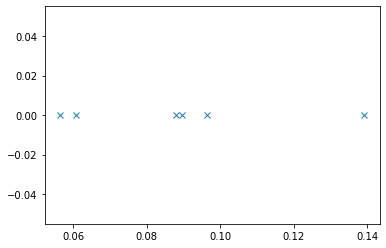

In [27]:
errors_list_anomalies = []
for i in range(len(result_lst)):
    errors_list_anomalies.append(result_lst[i][1])  

val = 0. # this is the value where you want the data to appear on the y-axis.
plt.plot(errors_list_anomalies, np.zeros_like(errors_list_anomalies) + val, 'x')
plt.show()

In [28]:
average_recon_error = np.mean(np.array(errors_list_anomalies))  
stdev_recon_error = np.std(np.array(errors_list_anomalies)) 
min_prob = np.min(errors_list_anomalies)
max_prob = np.max(errors_list_anomalies)
print("THIS IS FOR THE ANOMALY IMAGES\n")
print("The average of the errors list is: ", average_recon_error)
print("The standard deviation of the errors list is: ", stdev_recon_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

THIS IS FOR THE ANOMALY IMAGES

The average of the errors list is:  0.0884124551500593
The standard deviation of the errors list is:  0.02719800408699694
The min value of the errors list is:  0.05641514914376395
The max value of the errors list is:  0.1392558188665481


## Comparing the reconstruction error of anomaly and normal images

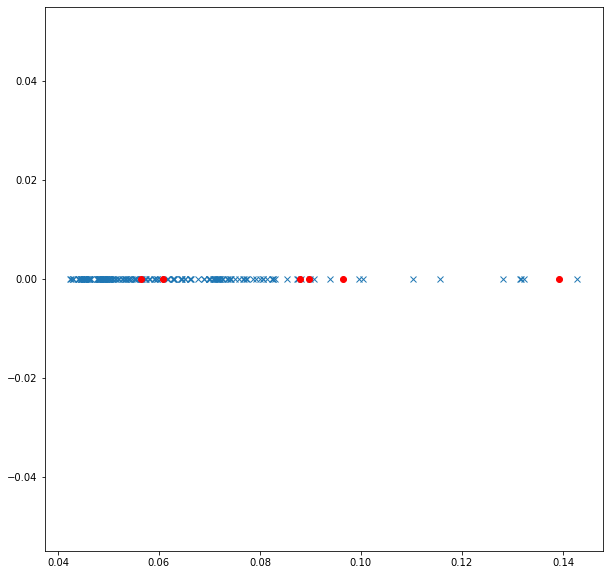

In [29]:
plt.figure(figsize=(10, 10))
val = 0. # this is the value where you want the data to appear on the y-axis.
plt.plot(errors_list, np.zeros_like(errors_list) + val, 'x')
plt.plot(errors_list_anomalies, np.zeros_like(errors_list_anomalies) + val, 'ro')
plt.show()

Above see that the reconstruction error between normal and anomaly images are NOT clearly divided in the plot. This could be a problem for the overall detection.

# Coding a function to check if an image contains anomalies

We know that for the non-anomaly images, the mean and std devation is:

In [30]:
na_avg_rcn_error = np.mean(np.array(errors_list))  
na_stdev_rcn_error = np.std(np.array(errors_list)) 
min_prob = np.min(errors_list)
max_prob = np.max(errors_list)
print("THIS IS FOR THE TRAINING (NON-ANOMALY) IMAGES\n")
print("The average of the errors list is: ", na_avg_rcn_error)
print("The standard deviation of the errors list is: ", na_stdev_rcn_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

THIS IS FOR THE TRAINING (NON-ANOMALY) IMAGES

The average of the errors list is:  0.06198303580252407
The standard deviation of the errors list is:  0.018923037896527585
The min value of the errors list is:  0.0424121447971889
The max value of the errors list is:  0.14284367788405644


And for the anomaly image, the std deviation and mean values are:

In [31]:
a_avg_rcn_error = np.mean(np.array(errors_list_anomalies))  
a_stdev_rcn_error = np.std(np.array(errors_list_anomalies)) 
min_prob = np.min(errors_list_anomalies)
max_prob = np.max(errors_list_anomalies)
print("THIS IS FOR THE TRAINING ANOMALY IMAGES\n")
print("The average of the errors list is: ", a_avg_rcn_error)
print("The standard deviation of the errors list is: ", a_stdev_rcn_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

THIS IS FOR THE TRAINING ANOMALY IMAGES

The average of the errors list is:  0.0884124551500593
The standard deviation of the errors list is:  0.02719800408699694
The min value of the errors list is:  0.05641514914376395
The max value of the errors list is:  0.1392558188665481


According to this, we will work with the following:

- The error value is 0.2160765. This is exactly the average of the non-anomaly distribution, then it should have a 0% probability of being detected as an anomaly image.
- The error value is 0.2160765 +/- 0.07979. Then the probability of being detected as an anomaly bottle is 50%. And, as typically, we decide that a value higher than 50% is considered as an anomaly image, then every value higher or lower than this quantity will be considered as an anomaly image.

In [32]:
def ranges_mapper(value, leftMin, leftMax, rightMin, rightMax):
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return rightMin + (valueScaled * rightSpan)

In [33]:
def map_error2prob(value):
    # Calculate the mean and standard deviation
    mean = na_avg_rcn_error
    std_dev = na_stdev_rcn_error
    aux_score = value - mean
    prob_score = ranges_mapper(abs(aux_score), 0, std_dev, 0, 50)
    if prob_score<0:
        prob_score = 0
    if prob_score>100:
        prob_score = 100
    return prob_score

Testing a reconstruction error. Verifying that given some reconstruction error, the probability value is the one we expect. 

In [34]:
print(map_error2prob(na_avg_rcn_error + na_stdev_rcn_error))

49.999999999999986


In [35]:
def map_error2prob_list(input_list):
    # Calculate the mean and standard deviation
    mean = na_avg_rcn_error
    std_dev = na_stdev_rcn_error
    prob_score_list = []
    for i in range (len(input_list)):
        aux_score = input_list[i] - mean
        prob_score = ranges_mapper(abs(aux_score), 0, std_dev, 0, 50)
        if prob_score<0:
            prob_score = 0
        if prob_score>100:
            prob_score = 100
        prob_score_list.append(prob_score)
    return prob_score_list

Checking the probability of being detected as anomaly images of the set of non-anomaly images. Ideally, all these images should output a probability of around 0%, because these are not anomaly images.

Moreover, we decide whether an image is anomaly or not, based on its reconstruction error.

In [36]:
print("Considering the non-anomaly dataset. The number of images to be cheked is: ", len(errors_list))
preds_probs = np.array(map_error2prob_list(errors_list))
preds_probs = preds_probs/100
print("The prediction probabilities list for the non-anomaly images is: ")
print(preds_probs)

Considering the non-anomaly dataset. The number of images to be cheked is:  179
The prediction probabilities list for the non-anomaly images is: 
[1.         1.         1.         1.         1.         1.
 1.         1.         0.99381176 0.84331604 0.76131477 0.73778152
 0.69261769 0.67736839 0.6719778  0.61706474 0.55574655 0.54533931
 0.54332986 0.53838715 0.51254237 0.49346556 0.4916844  0.47619136
 0.45527698 0.43955205 0.4069918  0.40153057 0.39453701 0.38518572
 0.36429775 0.34590355 0.32622976 0.32025361 0.31777213 0.31096546
 0.30193381 0.28066425 0.27660215 0.26723301 0.26632975 0.26220316
 0.26183972 0.25815455 0.25762088 0.25072512 0.24919594 0.2440866
 0.23956147 0.23540277 0.23058651 0.21572929 0.21118226 0.21118211
 0.20894137 0.18119933 0.18107319 0.15061523 0.11589044 0.10994818
 0.10911227 0.08346353 0.08346353 0.07070515 0.06461455 0.06258545
 0.06258545 0.02737108 0.02677021 0.02623608 0.02203134 0.02203134
 0.0035859  0.00874685 0.04595162 0.04613911 0.06357921 0.0

Let's now check the reconstruction error of the anomaly images.

In [37]:
print("Considering the anomaly dataset. The number of images to be cheked is: ", len(errors_list_anomalies))
preds_probs = np.array(map_error2prob_list(errors_list_anomalies))
preds_probs = preds_probs/100
print("The prediction probabilities list for the anomaly images is: ")
print(preds_probs)

Considering the anomaly dataset. The number of images to be cheked is:  6
The prediction probabilities list for the anomaly images is: 
[1.         0.90908752 0.7320314  0.68630615 0.03203201 0.14711926]


See that for the classification of the anomaly images we have:
- Three samples that were correctly identified as anomaly images.
- Three samples that were classified as non-anomaly. These are false negatives.


# Evaluating the performance of the model

So far, it has been used two dataset for doing the above tests: The full non-anomalies dataset and a full anomalies dataset. We will create a third dataset with a mix of these two types of images.

In [38]:
test_dir = '../../../Images/BottleStoodUp_atNight/Evaluation'      #This is for the home laptop
transform_characteristics = transforms.Compose([transforms.Grayscale(),
                                                transforms.ToTensor(),
                                                transforms.Resize(255),
                                                transforms.CenterCrop(224)])

dataset_test = datasets.ImageFolder(test_dir, transform=transform_characteristics)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=32, shuffle=True)
classes = ('non-anomaly','anomaly')

In [39]:
def computePred(err_value):
    pred = 0
    prob_anomaly = map_error2prob(err_value)/100
    if prob_anomaly > 0.5:
        pred = 1
    return pred


In [40]:
y_pred = []
y_true = []

# Grabbing only the first image of the anomalies dataset
X = dataset_test[0]
image_in_tensor = X[0]

n_features = len(image_in_tensor[0])  # Get the size of one image of the anomaly images dataset. This is supposed to be 224
for i in range(len(dataset_test)):
    X = dataset_test[i]
    image_in_tensor = X[0]
    image_in_tensor = image_in_tensor.cuda()            # If using the GPU
    ground_truth = X[1]

    with torch.no_grad():
        Y = model(image_in_tensor)  # should be same as X
    err = torch.sum((image_in_tensor-Y)*(image_in_tensor-Y)).item()  # SSE all features
    err = err/(n_features*3)        # dividing by n_features*3 becuase we have three channels
    prediction = computePred(err)
    y_pred.append(prediction) # Save Prediction
    y_true.append(ground_truth) # Save Truth
print(y_true)
print(y_pred)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Above, it can be seen that all the images are predicted to be anomaly images. This is good for the TPR but it is terrible for the FPR. It might be possible to improve the prediction by changing its probability-computation process, instead of being based on the Gaussian distribution, it could be based on a simple threshold. 

Below, it is seen the implementation of the function that computes the probability of the prediction based on a given threshold. We will start first by displaying the value of the reconstruction error of all the values of the test dataset.

In [41]:
result_test_lst = []

X = dataset_test[0]
image_in_tensor = X[0]

n_features = len(image_in_tensor[0])  # Get the size of one image of the anomaly images dataset. This is supposed to be 224
for i in range(len(dataset_test)):
    X = dataset_test[i]
    image_in_tensor = X[0]
    image_in_tensor = image_in_tensor.cuda()            # If using the GPU
    with torch.no_grad():
        Y = model(image_in_tensor)  # should be same as X
    err = torch.sum((image_in_tensor-Y)*(image_in_tensor-Y)).item()  # SSE all features
    err = err/(n_features*3)        # dividing by n_features*3 becuase we have three channels
    result_test_lst.append( (i,err) )     # idx of data item, err
print(result_test_lst)

[(0, 0.13569307327270508), (1, 0.1409596942719959), (2, 0.1469887892405192), (3, 0.1467705794743129), (4, 0.14903920037405832), (5, 0.1503579957144601), (6, 0.15696089608328684), (7, 0.1468569210597447), (8, 0.14207029342651367), (9, 0.14500573703220912), (10, 0.12751684870038713), (11, 0.1297750018891834), (12, 0.12931946345738002), (13, 0.13650099436442056), (14, 0.13966519492013113), (15, 0.13349637531098865), (16, 0.21100437073480516), (17, 0.19214462098621188), (18, 0.14768803687322707), (19, 0.13599913460867746), (20, 0.13586272512163436), (21, 0.1345398085457938), (22, 0.1343677384512765), (23, 0.13500026294163295), (24, 0.1367793083190918), (25, 0.21673238845098586), (26, 0.21613402593703496), (27, 0.21958771206083752), (28, 0.22194353739420572), (29, 0.22631897245134627)]


Inspectioning the min and max values of the anomaly and non-anomaly results we have:

In [42]:
rec_error_non_anomaly_lst = []
aux = result_test_lst[0:25]             # It only grabs the first 25 samples, because these correspond to non-anomaly images.
for i in range (len(aux)):
    rec_error_non_anomaly_lst.append(aux[i][1])

average_recon_error = np.mean(np.array(rec_error_non_anomaly_lst))  
stdev_recon_error = np.std(np.array(rec_error_non_anomaly_lst)) 

print("The min value of reconstruction error of the non-anomaly list is: ", min(rec_error_non_anomaly_lst))
print("The max value of reconstruction error of the non-anomaly list is: ", max(rec_error_non_anomaly_lst))

print("The average of the errors list is: ", average_recon_error)
print("The standard deviation of the errors list is: ", stdev_recon_error)

The min value of reconstruction error of the non-anomaly list is:  0.12751684870038713
The max value of reconstruction error of the non-anomaly list is:  0.21100437073480516
The average of the errors list is:  0.14481452260698588
The standard deviation of the errors list is:  0.018402843325577352


In [43]:
rec_error_anomaly_lst = []
aux = result_test_lst[25:29]        # The last 5 samples of this list correspond to the anomaly images. We know this beforehand.
for i in range (len(aux)):
    rec_error_anomaly_lst.append(aux[i][1])

average_recon_error = np.mean(np.array(rec_error_anomaly_lst))  
stdev_recon_error = np.std(np.array(rec_error_anomaly_lst)) 

print("The min value of reconstruction error of the anomaly list is: ", min(rec_error_anomaly_lst))
print("The max value of reconstruction error of the anomaly list is: ", max(rec_error_anomaly_lst))

print("The average of the errors list is: ", average_recon_error)
print("The standard deviation of the errors list is: ", stdev_recon_error)

The min value of reconstruction error of the anomaly list is:  0.21613402593703496
The max value of reconstruction error of the anomaly list is:  0.22194353739420572
The average of the errors list is:  0.218599415960766
The standard deviation of the errors list is:  0.002330440786331842


From above we can conclude that everything above 0.23 in reconstruction error will be considered as an anomaly image.

In [44]:
na_avg_rcn_error = np.mean(np.array(errors_list))  
na_stdev_rcn_error = np.std(np.array(errors_list)) 
min_prob = np.min(errors_list)
max_prob = np.max(errors_list)
print("THIS IS FOR THE TRAINING (NON-ANOMALY) IMAGES\n")
print("The average of the errors list is: ", na_avg_rcn_error)
print("The standard deviation of the errors list is: ", na_stdev_rcn_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

THIS IS FOR THE TRAINING (NON-ANOMALY) IMAGES

The average of the errors list is:  0.06198303580252407
The standard deviation of the errors list is:  0.018923037896527585
The min value of the errors list is:  0.0424121447971889
The max value of the errors list is:  0.14284367788405644


In [45]:
def map_error2prob_list_v2(input_list):
    threshold = 0.23    # This is the min value of the anomalies values 
    std_dev = 0.0044879      # This is the std deviation of the anomalies values 
    prob_score_list = []
    prob_score = 50
    for i in range (len(input_list)):
        aux_score = input_list[i] - threshold
        
        if aux_score>=0:
            additional = ranges_mapper(aux_score, 0, std_dev, 0, 50)
            prob_score_tot = prob_score+additional
        else:
            additional = ranges_mapper(abs(aux_score), 0, std_dev, 0, 50)
            prob_score_tot = prob_score-additional
        if prob_score_tot > 100:
            prob_score_tot = 100
        if prob_score_tot < 0:
            prob_score_tot = 0
        prob_score_list.append(prob_score_tot)
    return prob_score_list

In [46]:
def map_error2prob_v2(value):
    threshold = 0.23    # This is the min value of the anomalies values 
    std_dev = 0.0044879      # This is the std deviation of the anomalies values 
    prob_score = 50
    aux_score = value - threshold
        
    if aux_score>=0:
        additional = ranges_mapper(aux_score, 0, std_dev, 0, 50)
        prob_score_tot = prob_score+additional
    else:
        additional = ranges_mapper(abs(aux_score), 0, std_dev, 0, 50)
        prob_score_tot = prob_score-additional
    if prob_score_tot > 100:
        prob_score_tot = 100
    if prob_score_tot < 0:
        prob_score_tot = 0    
    return prob_score_tot

In [47]:
def computePred_v2(err_value):
    pred = 0
    prob_anomaly = map_error2prob_v2(err_value)/100
    if prob_anomaly > 0.5:
        pred = 1
    return pred

In [48]:
print("The prob of the error value of being anomaly image is: ", map_error2prob_v2(1.02))
print("Given the probability, it is actually predicted as:", computePred_v2(1.02))

The prob of the error value of being anomaly image is:  100
Given the probability, it is actually predicted as: 1


In [49]:
y_pred = []
y_true = []

# Grabbing only the first image of the anomalies dataset
X = dataset_test[0]
image_in_tensor = X[0]

n_features = len(image_in_tensor[0])  # Get the size of one image of the anomaly images dataset. This is supposed to be 224
for i in range(len(dataset_test)):
    X = dataset_test[i]
    image_in_tensor = X[0]
    image_in_tensor = image_in_tensor.cuda()            # If using the GPU
    ground_truth = X[1]

    with torch.no_grad():
        Y = model(image_in_tensor)  # should be same as X
    err = torch.sum((image_in_tensor-Y)*(image_in_tensor-Y)).item()  # SSE all features
    err = err/(n_features*3)        # dividing by n_features*3 becuase we have three channels

    prediction = computePred_v2(err)
    y_pred.append(prediction) # Save Prediction
    y_true.append(ground_truth) # Save Truth
print(y_true)
print(y_pred)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


See the above results. These are perfect results. BUT this was obtained in a way that is not completely correct because the threshold was selected based on the reconstruction errors of this test set!

The proper way to proceed, would be with the thresholds found in the section: "Coding a function to check if an image contains anomalies". Where it was coded a function that decides if an image is an anomaly or not, based on the Gaussian distribution of the reconstruction error of the samples. We could also try to implement here, a function that directly takes a threshold based on the min value of the anomalies reconstruction error, although this option is also not that good since it was seen that the reconstruction errors of the non-anomaly and anomaly were mixed.

Given the reasons exposed above, let's retake the code in section: "Coding a function to check if an image contains anomalies" in order to apply evaluation metrics on those results. 

## Retaking the functions whose thresholds rely on the training sets of images

First, we see the results with the Gaussian distribution. This is exactly the same as in a previous section above.

In [50]:
y_pred = []
y_true = []

# Grabbing only the first image of the anomalies dataset
X = dataset_test[0]
image_in_tensor = X[0]

n_features = len(image_in_tensor[0])  # Get the size of one image of the anomaly images dataset. This is supposed to be 224
for i in range(len(dataset_test)):
    X = dataset_test[i]
    image_in_tensor = X[0]
    image_in_tensor = image_in_tensor.cuda()            # If using the GPU
    ground_truth = X[1]

    with torch.no_grad():
        Y = model(image_in_tensor)  # should be same as X
    err = torch.sum((image_in_tensor-Y)*(image_in_tensor-Y)).item()  # SSE all features
    err = err/(n_features*3)        # dividing by n_features*3 becuase we have three channels

    prediction = computePred(err)
    y_pred.append(prediction) # Save Prediction
    y_true.append(ground_truth) # Save Truth
print(y_true)
print(y_pred)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Now, these results are correctly obtained. However, as indicated above, these results are poor, specially in terms of FPR.

We will try to implement a simpe threshold value rather than the Gaussian-distribution-based threshold. Recall that the description data for the anomalies and non-anomaly sets were:

In [51]:
result_lst = []
X = dataset[0]
image_in_tensor = X[0]
n_features = len(image_in_tensor[0])  # 65
for i in range(len(dataset)):
    X = dataset[i]
    image_in_tensor = X[0]
    image_in_tensor = image_in_tensor.cuda()            # If using the GPU
    with torch.no_grad():
        Y = model(image_in_tensor)  # should be same as X
    err = torch.sum((image_in_tensor-Y)*(image_in_tensor-Y)).item()  # SSE all features
    err = err/(n_features*3)        # dividing by n_features*3 becuase we have three channels
    result_lst.append( (i,err) )     # idx of data item, err
na_avg_rcn_error = np.mean(np.array(errors_list))  
na_stdev_rcn_error = np.std(np.array(errors_list)) 
min_error = np.min(errors_list)
max_error = np.max(errors_list)
print("FOR THE NON-ANOMALY IMAGES")
print("The average of the errors list is: ", na_avg_rcn_error)
print("The standard deviation of the errors list is: ", na_stdev_rcn_error)
print("The min value of the errors list is: ", min_error)
print("The max value of the errors list is: ", max_error)

FOR THE NON-ANOMALY IMAGES
The average of the errors list is:  0.06198303580252407
The standard deviation of the errors list is:  0.018923037896527585
The min value of the errors list is:  0.0424121447971889
The max value of the errors list is:  0.14284367788405644


In [52]:
# Grabbing only the first image of the anomalies dataset
X = dataset_anomalies[0]
image_in_tensor = X[0]
n_features = len(image_in_tensor[0])  # Get the size of one image of the anomaly images dataset. This is supposed to be 224
for i in range(len(dataset_anomalies)):
    X = dataset_anomalies[i]
    image_in_tensor = X[0]
    image_in_tensor = image_in_tensor.cuda()            # If using the GPU
    with torch.no_grad():
        Y = model(image_in_tensor)  # should be same as X
    err = torch.sum((image_in_tensor-Y)*(image_in_tensor-Y)).item()  # SSE all features
    err = err/(n_features*3)        # dividing by n_features*3 becuase we have three channels
    result_lst.append( (i,err) )     # idx of data item, err
a_avg_rcn_error = np.mean(np.array(errors_list_anomalies))  
a_stdev_rcn_error = np.std(np.array(errors_list_anomalies)) 
min_error = np.min(errors_list_anomalies)
max_error = np.max(errors_list_anomalies)
print("FOR THE ANOMALY IMAGES")
print("The average of the errors list is: ", a_avg_rcn_error)
print("The standard deviation of the errors list is: ", a_stdev_rcn_error)
print("The min value of the errors list is: ", min_error)
print("The max value of the errors list is: ", max_error)


FOR THE ANOMALY IMAGES
The average of the errors list is:  0.0884124551500593
The standard deviation of the errors list is:  0.02719800408699694
The min value of the errors list is:  0.05641514914376395
The max value of the errors list is:  0.1392558188665481


The following functions will be based on the average value of the anomaly images and the std deviation of the same set. Every reconstruction error that is above 0.3 will be considered as ANOMALY image.

In [53]:
def map_error2prob_list_v3(input_list):
    # threshold = na_avg_rcn_error         # This is the mean value of the non-anomalies values 
    # std_dev = na_stdev_rcn_error         # This is the std deviation of the non-anomalies values 
    
    # #These lines below could be used to be based on the anomaly values
    threshold = a_avg_rcn_error         # This is the mean value of the anomalies values 
    std_dev = a_stdev_rcn_error         # This is the std deviation of the anomalies values 

    prob_score_list = []
    prob_score = 50
    for i in range (len(input_list)):
        aux_score = input_list[i] - threshold
        
        if aux_score>=0:
            additional = ranges_mapper(aux_score, 0, std_dev, 0, 50)
            prob_score_tot = prob_score+additional
        else:
            additional = ranges_mapper(abs(aux_score), 0, std_dev, 0, 50)
            prob_score_tot = prob_score-additional
        if prob_score_tot > 100:
            prob_score_tot = 100
        if prob_score_tot < 0:
            prob_score_tot = 0
        prob_score_list.append(prob_score_tot)
    return prob_score_list

In [54]:
def map_error2prob_v3(value):
    # threshold = na_avg_rcn_error         # This is the mean value of the non-anomalies values 
    # std_dev = na_stdev_rcn_error         # This is the std deviation of the non-anomalies values 

    # #These lines below could be used to be based on the anomaly values 
    threshold = a_avg_rcn_error         # This is the mean value of the anomalies values 
    std_dev = a_stdev_rcn_error         # This is the std deviation of the anomalies values 
    prob_score = 50
    aux_score = value - threshold
        
    if aux_score>=0:
        additional = ranges_mapper(aux_score, 0, std_dev, 0, 50)
        prob_score_tot = prob_score+additional
    else:
        additional = ranges_mapper(abs(aux_score), 0, std_dev, 0, 50)
        prob_score_tot = prob_score-additional
    if prob_score_tot > 100:
        prob_score_tot = 100
    if prob_score_tot < 0:
        prob_score_tot = 0    
    return prob_score_tot

In [55]:
def computePred_v3(err_value):
    pred = 0
    prob_anomaly = map_error2prob_v3(err_value)/100
    if prob_anomaly > 0.5:
        pred = 1
    return pred

In [56]:
print("The prob of the error value of being anomaly image is: ", map_error2prob_v3(na_avg_rcn_error))
print("Given the probability, it is actually predicted as:", computePred_v3(na_avg_rcn_error))

The prob of the error value of being anomaly image is:  1.4129432751816466
Given the probability, it is actually predicted as: 0


In [57]:
y_pred = []
y_true = []

# Grabbing only the first image of the anomalies dataset
X = dataset_test[0]
image_in_tensor = X[0]

n_features = len(image_in_tensor[0])  # Get the size of one image of the anomaly images dataset. This is supposed to be 224
for i in range(len(dataset_test)):
    X = dataset_test[i]
    image_in_tensor = X[0]
    image_in_tensor = image_in_tensor.cuda()            # If using the GPU
    ground_truth = X[1]

    with torch.no_grad():
        Y = model(image_in_tensor)  # should be same as X
    err = torch.sum((image_in_tensor-Y)*(image_in_tensor-Y)).item()  # SSE all features
    err = err/(n_features*3)        # dividing by n_features*3 becuase we have three channels
    # print(err)
    prediction = computePred_v3(err)
    y_pred.append(prediction) # Save Prediction
    y_true.append(ground_truth) # Save Truth
print(y_true)
print(y_pred)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


THe same result is obtained, a poor performance in terms of FPR. However, these are the results that are correctly computed. With these results the evaluation metrics are calculated.

The problem of these poor results in terms of FPR is that the reconstruction error computed for the non-anomaly test images are very high with respect the average of the training images. It is strange to see why these images output a quite high reconstruction errors. 

Ideas for further testing:
- Create another test images set. 
- Try this program in a complete different images set.

## Applying evaluation metrics to these results

## Computing the confustion matrix

In [58]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

In [59]:
conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)

[[ 0 25]
 [ 0  5]]


Text(0.5, 15.0, 'Predicted label')

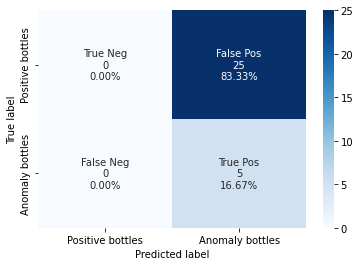

In [60]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                conf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]        #To print the group names as well 

labels = np.asarray(labels).reshape(2,2)
categories = ['Positive bottles', 'Anomaly bottles']
sn.heatmap(conf_matrix, annot=labels, fmt='', xticklabels=categories,yticklabels=categories, cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [61]:
_tp = conf_matrix[1, 1]
_fn = conf_matrix[1, 0]
_fp = conf_matrix[0, 1]
_tn = conf_matrix[0, 0]


## Precision metric

Precision = True positives / (True positives + False positives).

Answers the question: Which proportion of positive predictions is actually right?

In [62]:
precision = _tp/(_tp+_fp)
print("The precision is: ", precision)


The precision is:  0.16666666666666666


Poor results. It was expected.

## Recall metric

Recall = TruePositives / (TruePositives + FalseNegatives)

This metric is also called "sensitiviy" and TPR "True Positive Rate". It responds how good is the model at catching YESes?

In [63]:
recall = _tp/(_tp+_fn)
print("The recall is: ", recall)

The recall is:  1.0


## Specificity

Specificity = True negatives / (True negatives + false positives)

The specificity metric is the opposite as sensitivity, it tells us how good is the model at catching NOes. It measures the proportion of actual negatives that are correctly identified as such.

In [64]:
spec = _tn/(_tn+_fp)
print("The specificity is: ", spec)

The specificity is:  0.0


## Accuracy

Accuracy = (True negatives + True positives) / (True positives + True negatives + False positives + False negatives)

In [65]:
acc = (_tn+_tp)/(_tn+_tp +_fp + _fn)
print("The accuracy is: ", acc)

The accuracy is:  0.16666666666666666


## The ROC curve

In [66]:
from sklearn.metrics import roc_curve, roc_auc_score


Rather than the prediction of each sample (0 or 1 values) we need the probability of the samples to be predicted as an anomaly image. Hence, we compute this probability

In [67]:
rec_error_test_set = []

X = dataset_test[0]
image_in_tensor = X[0]

n_features = len(image_in_tensor[0])  # Get the size of one image of the anomaly images dataset. This is supposed to be 224
for i in range(len(dataset_test)):
    X = dataset_test[i]
    image_in_tensor = X[0]
    image_in_tensor = image_in_tensor.cuda()            # If using the GPU
    with torch.no_grad():
        Y = model(image_in_tensor)  # should be same as X
    err = torch.sum((image_in_tensor-Y)*(image_in_tensor-Y)).item()  # SSE all features
    err = err/(n_features*3)        # dividing by n_features*3 becuase we have three channels
    rec_error_test_set.append( err)     # idx of data item, err
print(rec_error_test_set)

c:\Users\alexj\.conda\envs\tfm_3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[0.13569307327270508, 0.1409596942719959, 0.1469887892405192, 0.1467705794743129, 0.14903920037405832, 0.1503579957144601, 0.15696089608328684, 0.1468569210597447, 0.14207029342651367, 0.14500573703220912, 0.12751684870038713, 0.1297750018891834, 0.12931946345738002, 0.13650099436442056, 0.13966519492013113, 0.1334963866642543, 0.21100437073480516, 0.19214459827968053, 0.14768804822649276, 0.13599913460867746, 0.13586272512163436, 0.1345398085457938, 0.1343677384512765, 0.13500026294163295, 0.1367793083190918, 0.21673238845098586, 0.21613402593703496, 0.21958771206083752, 0.22194353739420572, 0.22631897245134627]


In [68]:
y_prob = map_error2prob_list_v3(rec_error_test_set)
print(y_prob)

[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]


In [69]:
auc_score = roc_auc_score(y_true, y_prob)
print('AUROC = %.3f' % (auc_score))
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
print("The fpr is: ", fpr)
print("The tpr is: ", tpr)
print("The thresholds are: ", thresholds)

AUROC = 0.500
The fpr is:  [0. 1.]
The tpr is:  [0. 1.]
The thresholds are:  [101 100]


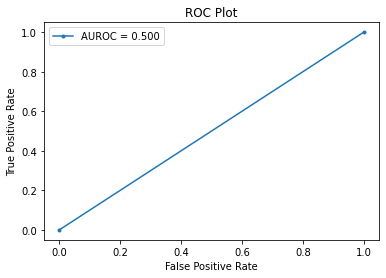

In [70]:
plt.plot(fpr, tpr, marker='.', label='AUROC = %0.3f' % auc_score)
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

Above can be seen that it was not possible to find some threshold value that was good for this model. This model is still bad in performance. It has to be executed another samples set of images, or another model configuration.